In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# 2. Creează o clasă personalizată pentru Dataset
class DataCustom(Dataset):
    def __init__(self, csv_file, folder_root, transform=None):
        self.folder_root = folder_root
        self.adnotari = pd.read_csv(csv_file)
        self.transformare = transform

    def __getitem__(self, id): # se surprascrie metoda pentru a putea folosi dataLoader
        ruta = f'{self.folder_root}/{self.adnotari.iloc[id, 0]}.png'
        image = Image.open(ruta).convert("RGB")
        eticheta = None
        if self.folder_root != 'Data/test':
            eticheta = int(self.adnotari.iloc[id, 1])

        if self.transformare:
            image = self.transformare(image)

        return image, eticheta

    def __len__(self):
        return len(self.adnotari)


transformare = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1, 1, 1]), # Normalizare, doar scadem media pentru imagini
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


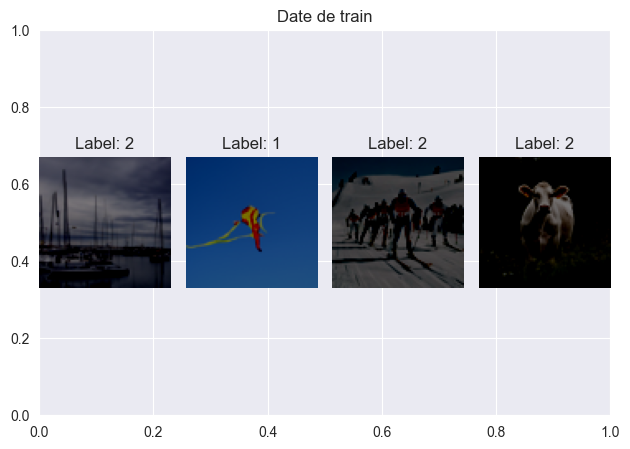

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


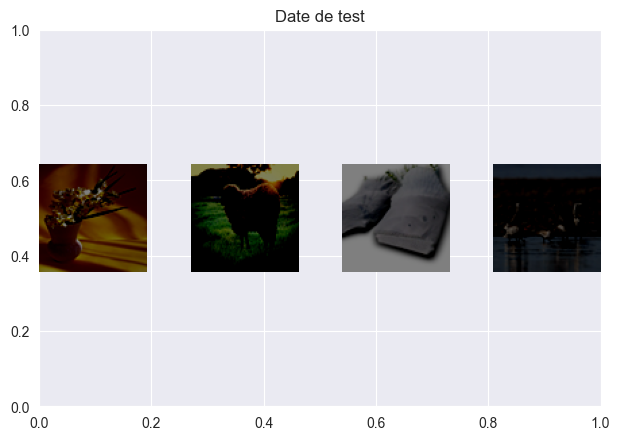

In [3]:
# datele de train sunt in Data/train.csv
fisier = 'Data/train.csv'
data = pd.read_csv(fisier)
folder_root = 'Data/train'
train_data = DataCustom(fisier, folder_root, transformare)

fisier = 'Data/validation.csv'
data = pd.read_csv(fisier)
folder_root = 'Data/validation'
data_validare = DataCustom(fisier, folder_root, transformare)

fisier = 'Data/test.csv'
data = pd.read_csv(fisier)
folder_root = ('Data/test')
test_data = DataCustom(fisier, folder_root, transformare)
# plotam imaginile si deasupra lor scriem label-ul
fig = plt.figure()
plt.title("Date de train")
# plotam cateva imagini de antrenare

for i in range(len(train_data)):
    image, eticheta = train_data[i]
    ax = plt.subplot(1, 4, i + 1)
    ax.set_title('Label: %d' % eticheta)
    ax.axis('off')
    plt.tight_layout()
    plt.imshow(image.permute(1, 2, 0))
    if i == 3:
        break
plt.show()
# plotam cateva imagini de test
fig = plt.figure()
plt.title("Date de test")
for i in range(len(test_data)):
    image = test_data[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')
    plt.imshow(image[0].permute(1, 2, 0))
    if i == 3:
        break
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ReteaConv(nn.Module):
    def __init__(self):
        super(ReteaConv, self).__init__()
        # 4 straturi convoluționale, 2 straturi complet conectate, 1 strat de pooling si functie de activare ReLU
        self.conv1 = nn.Conv2d(3, 32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, stride=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, stride=1, kernel_size=3, padding=1)
        self.sct1 = nn.Linear(256 * 5 * 5, 512)
        self.sct2 = nn.Linear(512, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        # pasul de forward folosind ReLU
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 5 * 5) # flatten pentru tensor
        x = F.relu(self.sct1(x))
        x = self.sct2(x)
        return x

# Instanțierea modelului
rc = ReteaConv()
rc.to(device)

ReteaConv(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sct1): Linear(in_features=6400, out_features=512, bias=True)
  (sct2): Linear(in_features=512, out_features=3, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
optimizator = torch.optim.Adam(rc.parameters(), lr=0.001)
criteriu = nn.CrossEntropyLoss()
epoci = 15
# incarcarea datelor si antrenare si validare
load_train = DataLoader(train_data, batch_size=32, shuffle=True)
load_validare = DataLoader(data_validare, batch_size=32, shuffle=False)

In [6]:
evolutie_loss_validare = []
evolutie_loss_train = []
evolutie_precizie_train = []
evolutie_precizie_validare = []

In [7]:
def validate():
    val_loss = 0.0
    corect = 0
    rc.eval()
    total = 0
    torch.no_grad()# nu se calculeaza gradientul
    for input, eticheta in load_validare:
        input, eticheta = input.to(device), eticheta.to(device)
        output = rc(input)
        loss = criteriu(output, eticheta)
        val_loss += loss.item()
        _, predictie = torch.max(output, 1)
        total += eticheta.size(0)
        corect += (predictie == eticheta).sum().item()
    torch.set_grad_enabled(True) # reactivam caluculul gradientului
    print(f'Pierdere validre: {val_loss / len(load_validare)}, Precizie validare: {corect / total}')
    evolutie_loss_validare.append(val_loss / len(load_validare))
    evolutie_precizie_validare.append(corect / total)

In [8]:
for epoca in range(epoci):
    rc.train()
    pierdere_c = 0.0
    corect = 0
    for input, eticheta in load_train:
        input, eticheta = input.to(device), eticheta.to(device)
        optimizator.zero_grad() # resetam gradientii ca sa nu se adune
        outputs = rc(input)
        loss = criteriu(outputs, eticheta)
        loss.backward() # calculam gradientii
        optimizator.step() # facem un pas in directia opusa gradientului
        pierdere_c += loss.item()
        _, predictie = torch.max(outputs, 1)
        corect += (predictie == eticheta).sum().item()
    validate()
    print(f"Epoca {epoca + 1}, Pierdere antrenament: {pierdere_c / len(load_train)}, Precizie antrenament: {corect / len(load_train)}")
    evolutie_loss_train.append(pierdere_c / len(load_train))
    evolutie_precizie_train.append(corect / len(load_train))

Pierdere validre: 1.05944472931801, Precizie validare: 0.44566666666666666
Epoca 1, Pierdere antrenament: 1.0467059016227722, Precizie antrenament: 14.632218844984802


KeyboardInterrupt: 

In [ ]:
def matrice_de_confuzie(y_corect, y_prezis, classes):
    mc = confusion_matrix(y_corect, y_prezis)
    plt.figure(figsize=(10, 8))
    sns.heatmap(mc, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Eticheta adevarata')
    plt.xlabel('Eticheta prezisa')
    plt.show()

In [ ]:
rc.eval()
y_corect = []
y_prezis = []
for input, eticheta in data_validare:
    output = rc(input)
    _, predictie = torch.max(output, 1)
    y_corect.extend(eticheta.tolist())
    y_prezis.extend(predictie.tolist())

matrice_de_confuzie(y_corect, y_prezis, ['0', '1', '2'])

In [ ]:
def plot_grafice():
    plt.plot(evolutie_loss_train, label='Pierdere antrenament')
    plt.plot(evolutie_loss_validare, label='Pierdere validare')
    plt.xlabel('Epoci')
    plt.ylabel('Pierdere')
    plt.legend()
    plt.show()
    plt.plot(evolutie_precizie_validare, label='Precizie validare')
    plt.xlabel('Epoci')
    plt.ylabel('Precizie')
    plt.legend()
    plt.show()

matrice_de_confuzie(y_corect, y_prezis, ['0', '1', '2'])
plot_grafice()

In [ ]:
print(evolutie_precizie_validare)